# 3.2 使用nn构建一个网络模型。

* 手写数字识别，数据集：MNIST

In [34]:
import numpy as np
import torch
from torchvision.datasets import mnist
import torchvision.transforms as transforms # 预处理模块
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [35]:
# 超参

train_batch_size = 64
test_batch_size = 128
lr = 0.01
num_epoches = 20
momentum = 0.5

In [36]:
# 数据预处理

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

train_dataset = mnist.MNIST('./data',train=True,transform=transform,download=True)
test_dataset = mnist.MNIST('./data',train=False,transform=transform)

train_loader = DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=test_batch_size,shuffle=False)

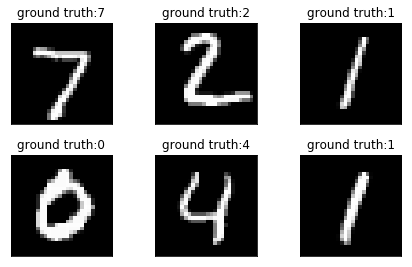

In [37]:
# 数据可视化
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title(f"ground truth:{example_targets[i]}")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [38]:
# 构建模型

class Net(nn.Module):
    """
    使用sequential构建网络，sequential()函数的功能就是将网络的层组合到一起
    """
    def __init__(self,in_dim,n_hidden_1,n_hidden_2,out_dim):
        super(Net,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim,n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1,n_hidden_2,nn.BatchNorm1d(n_hidden_2)))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2,out_dim))
        
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [39]:
# 实例化网络

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net(28*28,300,100,10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)

In [40]:
# 开始训练

losses = []
acces = []
eval_losses = []
eval_acces = []

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    
    # 训练模式
    model.train()
    
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.1
        
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0),-1)
        
        out = model(img)
        loss = criterion(out,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        _,pred = out.max(1)
        num_correct = (pred==label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0),-1)
        out = model(img)
        loss = criterion(out,label)
        eval_loss+=loss.item()
        _,pred=out.max(1)
        num_correct = (pred==label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc+=acc
    
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print(f'epoch: {epoch}, Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_acc / len(train_loader):.4f}, Test Loss: {eval_loss / len(test_loader):.4f}, Test Acc: {eval_acc / len(test_loader):.4f}')

epoch: 0, Train Loss: 1.6164, Train Acc: 0.6340, Test Loss: 0.9126, Test Acc: 0.8367
epoch: 1, Train Loss: 0.6789, Train Acc: 0.8563, Test Loss: 0.4749, Test Acc: 0.8913
epoch: 2, Train Loss: 0.4423, Train Acc: 0.8894, Test Loss: 0.3533, Test Acc: 0.9123
epoch: 3, Train Loss: 0.3579, Train Acc: 0.9039, Test Loss: 0.2947, Test Acc: 0.9216
epoch: 4, Train Loss: 0.3115, Train Acc: 0.9149, Test Loss: 0.2612, Test Acc: 0.9300
epoch: 5, Train Loss: 0.2926, Train Acc: 0.9198, Test Loss: 0.2605, Test Acc: 0.9282
epoch: 6, Train Loss: 0.2884, Train Acc: 0.9203, Test Loss: 0.2562, Test Acc: 0.9307
epoch: 7, Train Loss: 0.2850, Train Acc: 0.9223, Test Loss: 0.2539, Test Acc: 0.9301
epoch: 8, Train Loss: 0.2822, Train Acc: 0.9227, Test Loss: 0.2528, Test Acc: 0.9312
epoch: 9, Train Loss: 0.2797, Train Acc: 0.9223, Test Loss: 0.2500, Test Acc: 0.9318
epoch: 10, Train Loss: 0.2784, Train Acc: 0.9226, Test Loss: 0.2489, Test Acc: 0.9326
epoch: 11, Train Loss: 0.2783, Train Acc: 0.9230, Test Loss: 0.2

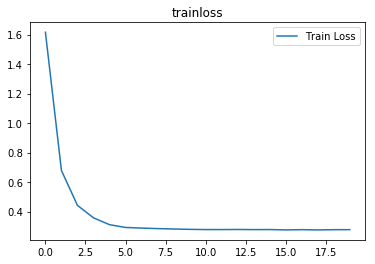

In [41]:
# 可视化训练及测试损失值

plt.title('trainloss')
plt.plot(np.arange(len(losses)),losses)
plt.legend(['Train Loss'],loc='upper right')

# 3.3 如何构建神经网络?

In [42]:
# 采用字典方式构建网络的一个示例代码:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net4,self).__init__()
        self.conv = torch.nn.Sequential(
            OrderedDict(
                [
                    ("conv1",torch.nn.Conv2d(3,32,3,1,1)),
                    ("relu1", torch.nn.ReLU()),
                    ("pool", torch.nn.MaxPool2d(2))
                ]
            )
        )
        self.dense = torch.nn.Sequential(
            OrderedDict(
                [
                    ("dense1",torch.nn.Linear(32 * 3 * 3, 128)),
                    ("relu1", torch.nn.ReLU()),
                    ("dense2", torch.nn.Linear(128, 10))
                ]
            )
        )

## 3.4.1 nn.module

## 3.4.2 nn.functional

* 一类是继承了nn.Module,其命名一般为nn.Xxx(第一个是大写),如nn.Linear、nn.Conv2d、nn.CrossEntropyLoss等。另一类是nn.functional中的函数

* 另一类是nn.functional中的函数,其名称一般为nn.funtional.xxx,如nn.funtional.linear、nn.funtional.conv2d、nn.funtional.cross_entropy等

* 性能方面两者也没有太大差异
* nn.Xxx继承于nn.Module,nn.Xxx需要先实例化并传入参数,然后以函数调用的方式调用实例化的对象并传入输入数据。它能够很好地与nn.Sequential结合使用,而nn.functional.xxx无法与nn.Sequential结合使用。

* nn.Xxx不需要自己定义和管理weight、bias参数;而nn.functional.xxx需要自己定义weight、bias参数,每次调用的时候都需要手动传入weight、bias等参数,不利于代码复用。

* Dropout操作在训练和测试阶段是有区别的,使用nn.Xxx方式定义Dropout,在调用model.eval()之后,自动实现状态的转换,而使用nn.functional.xxx却无此功能。

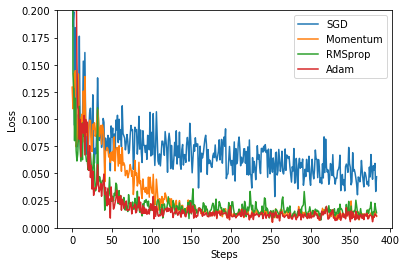

In [43]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
# 超参数
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12


x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)

y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))
torch_dataset = Data.TensorDataset(x,y)
# 得到一个代批量的生成器
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)
    # 前向传递
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
    
net_SGD = Net()
net_Momentum = Net()
net_RMSProp = Net()
net_Adam = Net()

nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]

loss_func = torch.nn.MSELoss()
loss_his = [[], [], [], []] # 记录损失
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt,l_his in zip(nets, optimizers, loss_his):
            output = net(batch_x) # get output for every net
            loss = loss_func(output, batch_y) # compute loss for every net
            opt.zero_grad() # clear gradients for next train
            loss.backward() # backpropagation, compute gradients
            opt.step() # apply gradients
            l_his.append(loss.data.numpy()) # loss recoder
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']


for i, l_his in enumerate(loss_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()